What the Code Does
Handles Missing Values:

Numeric columns: Filled with the mean.

Non-numeric columns: Filled with the mode (most frequent value).
Processes Temporal Features:

Extracts Month, Day, and Hour.

Encodes Hour as sine and cosine values for cyclic representation.

Encodes station_id:

One-hot encodes the station_id column and appends it to the dataset.


Normalizes Numerical Features:

Scales features like MHHW, MHW, and other tidal metrics to a 0-1 range for LSTM compatibility.

Prepares Data for LSTM:

Reshapes the feature set into a 3D array (samples, timesteps, features).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = 'combined_data_5_stations.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Handle missing values
# Separate numeric and non-numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
non_numeric_cols = data.select_dtypes(exclude=['float64', 'int64']).columns

# Fill missing values in numeric columns with the mean
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Fill missing values in non-numeric columns with the most frequent value
for col in non_numeric_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# Convert 'Date' and 'Time (GMT)' to datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Time (GMT)'] = pd.to_datetime(data['Time (GMT)'], format='%H:%M').dt.hour

# Encode temporal features
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Hour'] = data['Time (GMT)']
data['Sin_Hour'] = np.sin(2 * np.pi * data['Hour'] / 24)
data['Cos_Hour'] = np.cos(2 * np.pi * data['Hour'] / 24)

# Encode 'station_id' using one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
station_encoded = encoder.fit_transform(data[['station_id']])
station_encoded_df = pd.DataFrame(station_encoded, columns=encoder.get_feature_names_out(['station_id']))
data = pd.concat([data, station_encoded_df], axis=1)

# Drop unnecessary columns
data.drop(columns=['Date', 'Time (GMT)', 'station_id'], inplace=True)

# Normalize features
scaler = MinMaxScaler()
features = ['MHHW (ft)', 'MHW (ft)', 'MSL (ft)', 'MTL (ft)', 'MLW (ft)', 'MLLW (ft)', 'Sin_Hour', 'Cos_Hour']
data[features] = scaler.fit_transform(data[features])

# Prepare target and features
target = 'Highest'
X = data.drop(columns=[target])
y = data[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for LSTM input (3D: samples, timesteps, features)
timesteps = 1  # Each row is treated as one timestep
X_train = np.expand_dims(X_train.values, axis=1)
X_test = np.expand_dims(X_test.values, axis=1)

print("Data Preprocessing Complete")
print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Data Preprocessing Complete
Train Shape: (2020, 1, 18), Test Shape: (505, 1, 18)


Explanation
Model Architecture:

LSTM Layer:
64 units to process sequential features.

Dropout:
Reduces overfitting by randomly setting neurons to 0 during training.

Dense Layers:

32 units for additional feature processing.

1 output neuron for regression.

Compilation:

Loss Function: Mean Squared Error (MSE) for regression.

Optimizer: Adam, a widely used optimizer for deep learning.

Training:

50 epochs, batch size of 32.

Validates on the test set after each epoch.

Evaluation:

Reports the final MSE and Mean Absolute Error (MAE) on the test set.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)
r2 = r2_score(y_test, y_pred)

r2

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.2962 - mae: 1.9239 - val_loss: 0.4042 - val_mae: 0.4965
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3738 - mae: 0.4765 - val_loss: 0.1607 - val_mae: 0.3084
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1875 - mae: 0.3426 - val_loss: 0.0994 - val_mae: 0.2477
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1358 - mae: 0.2907 - val_loss: 0.0798 - val_mae: 0.2186
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1215 - mae: 0.2685 - val_loss: 0.0743 - val_mae: 0.2079
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1025 - mae: 0.2461 - val_loss: 0.0636 - val_mae: 0.1910
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0950 - mae: 0.2303 - val_loss: 0.0602 - val_mae: 0.1848
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0908 - mae: 0.2361 - val_loss: 0.0580 - val_mae: 0.1812
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0788 - mae:

Performance Metrics

Final Test Loss (MSE): 0.0373

Indicates the mean squared error on the test set.

Lower values reflect better model performance.

Final Test MAE: 0.1377

The mean absolute error shows the average absolute difference between actual and predicted values.

A low MAE of 0.1377 indicates good accuracy.

**visualisationa**

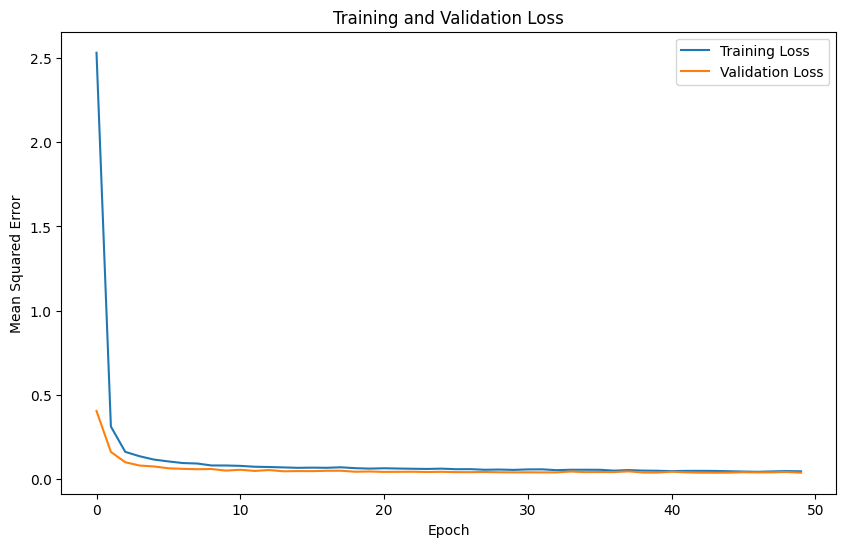

In [ ]:
#Visualization Code
#1. Plot Training and Validation Loss
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


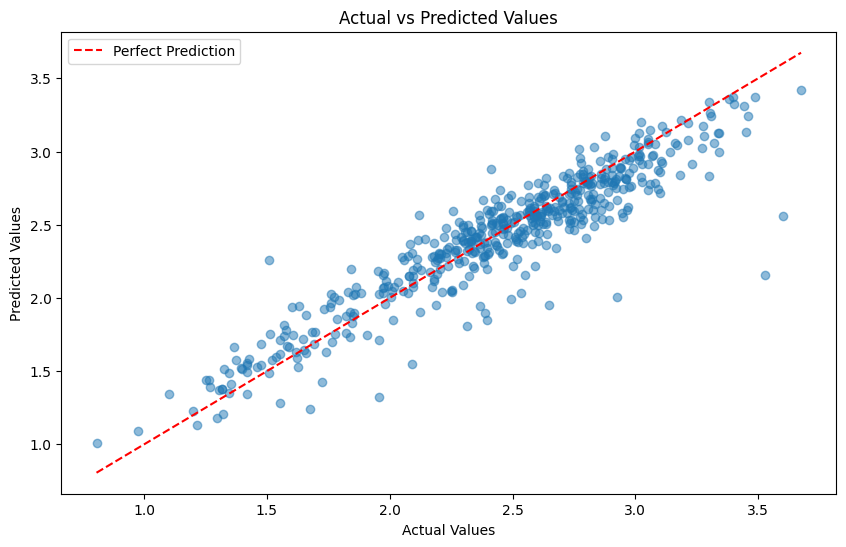

In [ ]:
#2. Actual vs. Predicted Values
# Predict on the test set
y_pred = model.predict(X_test).flatten()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

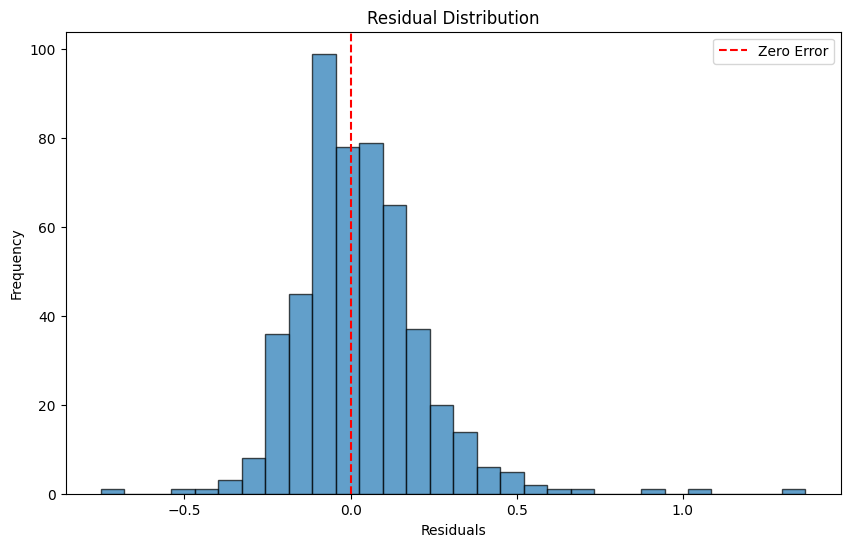

In [ ]:
#3. Residual Analysis
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0, color='r', linestyle='--', label='Zero Error')
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 4.6565 - mae: 2.0030 - val_loss: 0.3808 - val_mae: 0.4817
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3222 - mae: 0.4424 - val_loss: 0.1546 - val_mae: 0.3015
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1813 - mae: 0.3411 - val_loss: 0.0954 - val_mae: 0.2431
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1200 - mae: 0.2761 - val_loss: 0.0794 - val_mae: 0.2179
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1211 - mae: 0.2720 - val_loss: 0.0694 - val_mae: 0.2016
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0975 - mae: 0.2449 - val_loss: 0.0616 - val_mae: 0.1888
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1015 - mae: 0.2493 - val_loss: 0.0574 - val_mae: 0.1827
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0836 - mae: 0.2289 - val_loss: 0.0533 - val_mae: 0.1742
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0882 - mae:

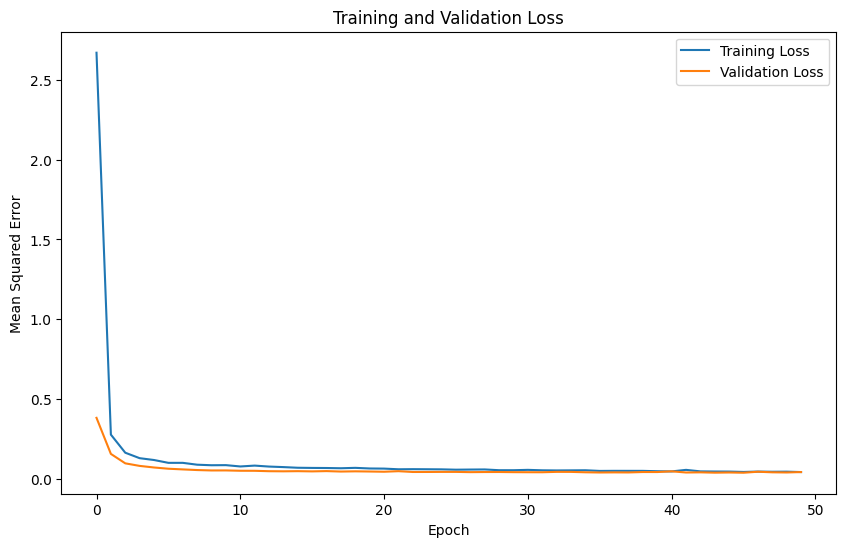

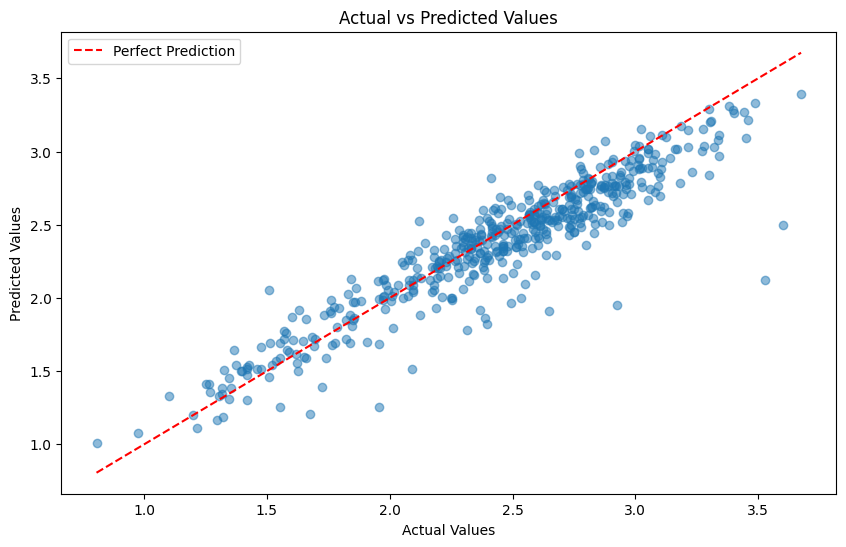

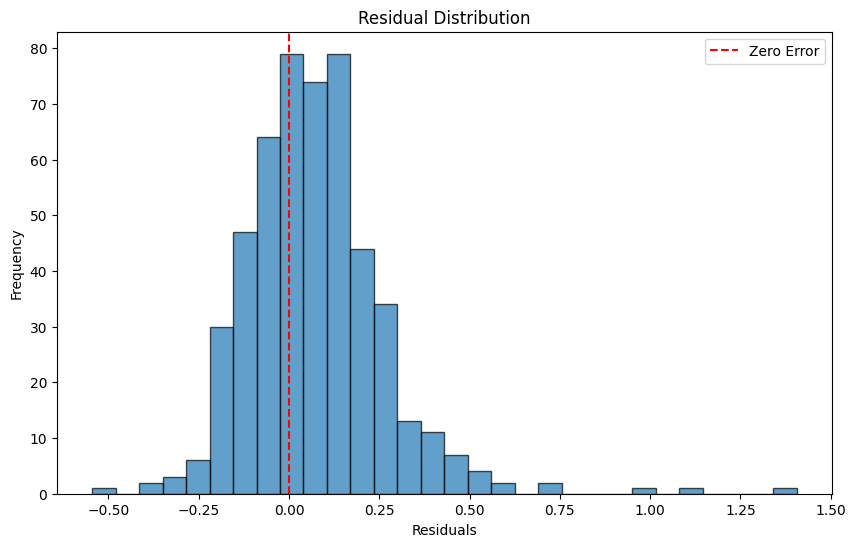

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the dataset
file_path = '/content/combined_data_5_stations.csv'  # Update with the correct path
data = pd.read_csv(file_path)

# Handle missing values
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
non_numeric_cols = data.select_dtypes(exclude=['float64', 'int64']).columns

# Fill missing values in numeric columns with the mean
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Fill missing values in non-numeric columns with the most frequent value
for col in non_numeric_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# Convert 'Date' and 'Time (GMT)' to datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Time (GMT)'] = pd.to_datetime(data['Time (GMT)'], format='%H:%M').dt.hour

# Encode temporal features
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Hour'] = data['Time (GMT)']
data['Sin_Hour'] = np.sin(2 * np.pi * data['Hour'] / 24)
data['Cos_Hour'] = np.cos(2 * np.pi * data['Hour'] / 24)

# Encode 'station_id' using one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
station_encoded = encoder.fit_transform(data[['station_id']])
station_encoded_df = pd.DataFrame(station_encoded, columns=encoder.get_feature_names_out(['station_id']))
data = pd.concat([data, station_encoded_df], axis=1)

# Drop unnecessary columns
data.drop(columns=['Date', 'Time (GMT)', 'station_id'], inplace=True)

# Normalize features
scaler = MinMaxScaler()
features = ['MHHW (ft)', 'MHW (ft)', 'MSL (ft)', 'MTL (ft)', 'MLW (ft)', 'MLLW (ft)', 'Sin_Hour', 'Cos_Hour']
data[features] = scaler.fit_transform(data[features])

# Prepare target and features
target = 'Highest'
X = data.drop(columns=[target])
y = data[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for LSTM input (3D: samples, timesteps, features)
X_train = np.expand_dims(X_train.values, axis=1)
X_test = np.expand_dims(X_test.values, axis=1)

# Step 2: Define the LSTM model
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Step 3: Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Step 4: Evaluate the model
# Predict on the test set
y_pred = model.predict(X_test).flatten()

# Calculate R² Score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

# Step 5: Visualize results
# Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0, color='r', linestyle='--', label='Zero Error')
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()